# Demo Notebook on how to load the transfer core and train a model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [3]:
from lurz2020.datasets.mouse_loaders import static_loaders

paths = [r"D:\inception_loop\original_code\lurz2020\static20457-5-9-preproc0"]

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)

### Look at the data

In [5]:
static_loaders??

In [4]:
tier = 'train'
dataset_name = '20457-5-9-0'

images, responses = [], []
for x, y in dataloaders[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20457-5-9-0" contains the responses of 5335 neurons to 4472 images


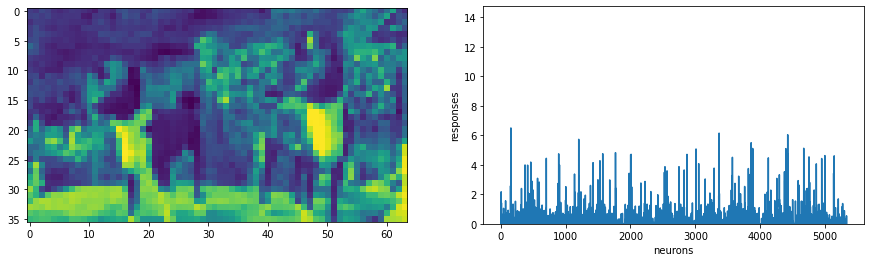

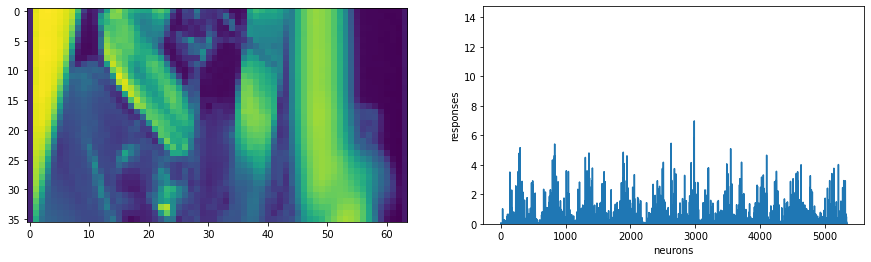

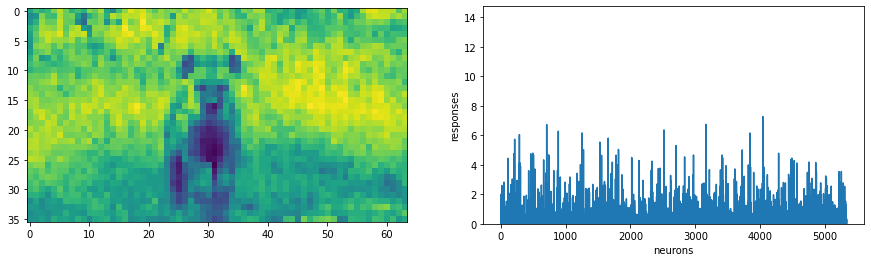

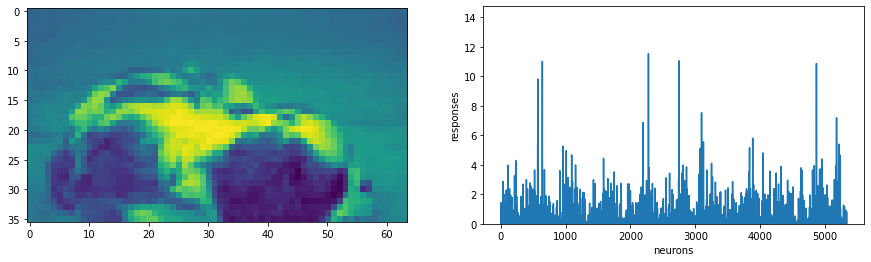

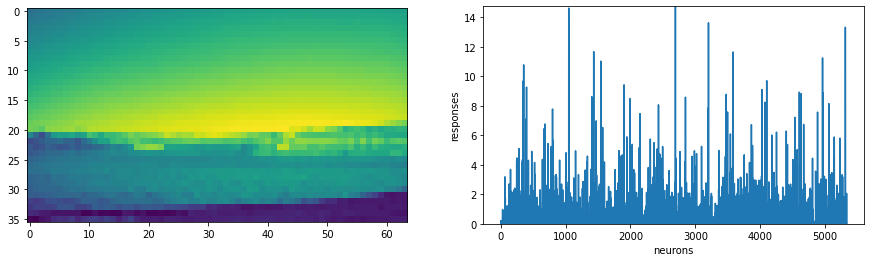

In [5]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model

If you want to load the transfer core later on, the arguments in the model config that concern the architecture of the model can not be changed. The following config was used in the paper (all arguments not in the config have the default value of the function).

In [6]:
from lurz2020.models.models import se2d_fullgaussian2d

model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439}

model = se2d_fullgaussian2d(**model_config, dataloaders=dataloaders, seed=1)

## Load the weights of the transfer core

This will load the weights of the transfer core onto the model that you built above. The argument `strict=False` ensures that only matching keys are loaded. The readout keys are thus discarded.

In [7]:
transfer_model = torch.load('models/transfer_model.pth.tar') 
model.load_state_dict(transfer_model, strict=False)

_IncompatibleKeys(missing_keys=['readout.20457-5-9-0.sigma', 'readout.20457-5-9-0._features', 'readout.20457-5-9-0.bias', 'readout.20457-5-9-0.source_grid', 'readout.20457-5-9-0.mu_transform.0.weight', 'readout.20457-5-9-0.mu_transform.0.bias'], unexpected_keys=['readout.22564-2-12-0.sigma', 'readout.22564-2-12-0._features', 'readout.22564-2-12-0.bias', 'readout.22564-2-12-0.source_grid', 'readout.22564-2-12-0.mu_transform.0.weight', 'readout.22564-2-12-0.mu_transform.0.bias', 'readout.22564-2-13-0.sigma', 'readout.22564-2-13-0._features', 'readout.22564-2-13-0.bias', 'readout.22564-2-13-0.source_grid', 'readout.22564-2-13-0.mu_transform.0.weight', 'readout.22564-2-13-0.mu_transform.0.bias', 'readout.22564-3-8-0.sigma', 'readout.22564-3-8-0._features', 'readout.22564-3-8-0.bias', 'readout.22564-3-8-0.source_grid', 'readout.22564-3-8-0.mu_transform.0.weight', 'readout.22564-3-8-0.mu_transform.0.bias', 'readout.22564-3-12-0.sigma', 'readout.22564-3-12-0._features', 'readout.22564-3-12-0.

# Build the trainer

In [8]:
from lurz2020.training.trainers import standard_trainer as trainer

# If you want to allow fine tuning of the core, set detach_core to False
detach_core=True
if detach_core:
    print('Core is fixed and will not be fine-tuned')
else:
    print('Core will be fine-tuned')

trainer_config = {'track_training': True,
                  'detach_core': detach_core}

Core is fixed and will not be fine-tuned


# Run training

In [9]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1, **trainer_config)

correlation -0.00083923974
poisson_loss 3445073.0


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 22.91it/s]


[001|00/05] ---> 0.20053380727767944
correlation 0.2005338
poisson_loss 1811638.6


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.82it/s]


[002|00/05] ---> 0.24912585318088531
correlation 0.24912585
poisson_loss 1744518.5


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 23.23it/s]


[003|00/05] ---> 0.28310322761535645
correlation 0.28310323
poisson_loss 1698222.8


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.31it/s]


[004|00/05] ---> 0.30215194821357727
correlation 0.30215195
poisson_loss 1667882.0


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.08it/s]


[005|00/05] ---> 0.31185322999954224
correlation 0.31185323
poisson_loss 1652855.0


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.48it/s]


[006|00/05] ---> 0.3154659867286682
correlation 0.315466
poisson_loss 1646226.8


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.51it/s]


[007|00/05] ---> 0.3205491602420807
correlation 0.32054916
poisson_loss 1640162.1


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.19it/s]


[008|00/05] ---> 0.3220966160297394
correlation 0.32209662
poisson_loss 1638156.2


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.13it/s]


[009|00/05] ---> 0.3229318857192993
correlation 0.3229319
poisson_loss 1635760.8


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.46it/s]


[010|01/05] -/-> 0.32268133759498596
correlation 0.32268134
poisson_loss 1636208.2


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.32it/s]


[011|01/05] ---> 0.32408106327056885
correlation 0.32408106
poisson_loss 1634122.0


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.74it/s]


[012|00/05] ---> 0.3244241178035736
correlation 0.32442412
poisson_loss 1634828.5


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.91it/s]


[013|00/05] ---> 0.3250419497489929
correlation 0.32504195
poisson_loss 1633132.8


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.77it/s]


[014|01/05] -/-> 0.32348862290382385
correlation 0.32348862
poisson_loss 1635945.5


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.32it/s]


[015|02/05] -/-> 0.32351163029670715
correlation 0.32351163
poisson_loss 1635764.2


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.66it/s]


[016|03/05] -/-> 0.3239840865135193
correlation 0.3239841
poisson_loss 1634131.2


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.71it/s]


[017|04/05] -/-> 0.3237698972225189
correlation 0.3237699
poisson_loss 1634826.8


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.47it/s]


[018|05/05] -/-> 0.3247181177139282
Restoring best model after lr decay! 0.324718 ---> 0.325042
correlation 0.32504195
poisson_loss 1633132.8


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:03<00:00, 23.14it/s]


Epoch    19: reducing learning rate of group 0 to 1.5000e-03.
[019|01/05] -/-> 0.3236595392227173
correlation 0.32365954
poisson_loss 1634698.8


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.65it/s]


[020|01/05] ---> 0.32523393630981445
correlation 0.32523394
poisson_loss 1631482.1


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.63it/s]


[021|01/05] -/-> 0.32456669211387634
correlation 0.3245667
poisson_loss 1633372.8


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.43it/s]


[022|01/05] ---> 0.3252577781677246
correlation 0.32525778
poisson_loss 1632270.5


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.58it/s]


[023|00/05] ---> 0.3257191777229309
correlation 0.32571918
poisson_loss 1630543.2


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.47it/s]


[024|01/05] -/-> 0.32546114921569824
correlation 0.32546115
poisson_loss 1630695.6


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.62it/s]


[025|02/05] -/-> 0.32560136914253235
correlation 0.32560137
poisson_loss 1630180.5


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.95it/s]


[026|02/05] ---> 0.32591506838798523
correlation 0.32591507
poisson_loss 1630440.2


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 23.88it/s]


[027|01/05] -/-> 0.3252617120742798
correlation 0.3252617
poisson_loss 1631115.9


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.18it/s]


[028|02/05] -/-> 0.32546332478523254
correlation 0.32546332
poisson_loss 1630458.9


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.46it/s]


[029|03/05] -/-> 0.32438889145851135
correlation 0.3243889
poisson_loss 1632611.5


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.50it/s]


[030|04/05] -/-> 0.3258495628833771
correlation 0.32584956
poisson_loss 1630405.5


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.64it/s]


[031|05/05] -/-> 0.3250479996204376
Restoring best model after lr decay! 0.325048 ---> 0.325915
correlation 0.32591507
poisson_loss 1630440.2


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.78it/s]


Epoch    32: reducing learning rate of group 0 to 4.5000e-04.
[032|01/05] -/-> 0.32499662041664124
correlation 0.32499662
poisson_loss 1631995.9


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.77it/s]


[033|02/05] -/-> 0.32553309202194214
correlation 0.3255331
poisson_loss 1631385.1


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.60it/s]


[034|03/05] -/-> 0.32541680335998535
correlation 0.3254168
poisson_loss 1631055.5


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.55it/s]


[035|04/05] -/-> 0.3254639804363251
correlation 0.32546398
poisson_loss 1630692.6


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 24.30it/s]


[036|05/05] -/-> 0.32518330216407776
Restoring best model after lr decay! 0.325183 ---> 0.325915
Restoring best model! 0.325915 ---> 0.325915


# Analyze the trained model

### Predict neural responses to an image (here from the train set)

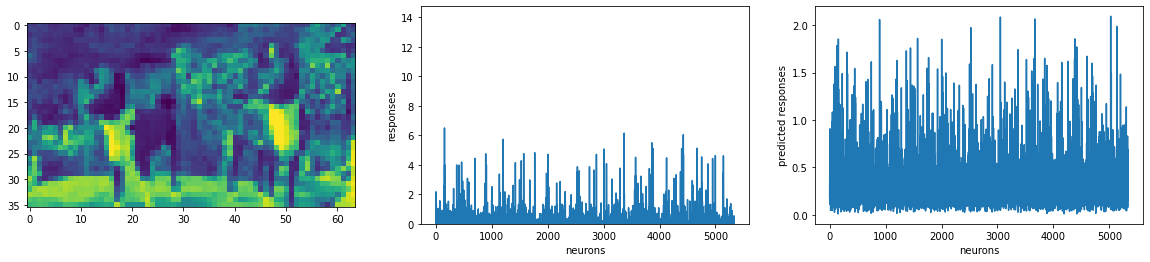

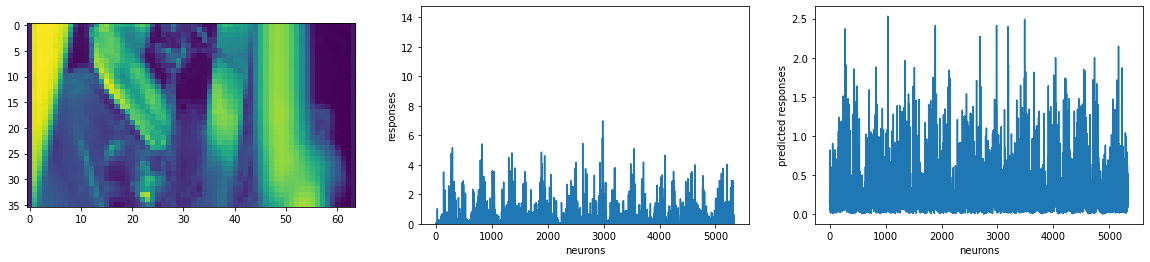

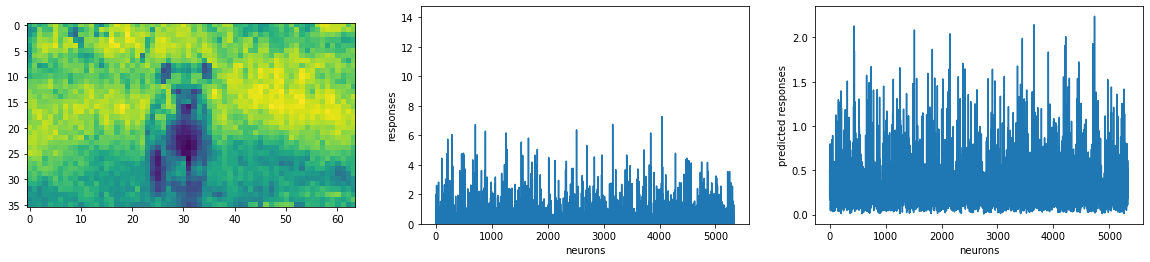

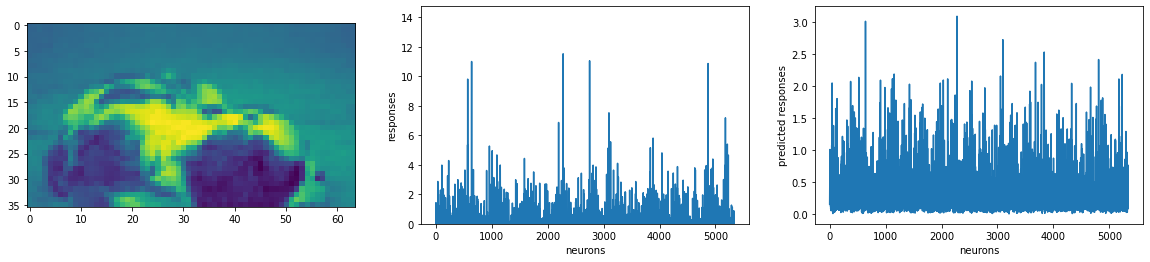

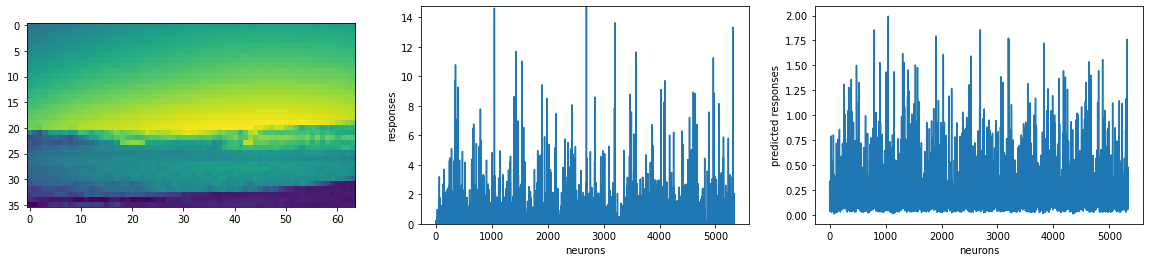

In [10]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    predicted_response = model(torch.from_numpy(input_image).view(1,1,36,64).cuda())
    predicted_response = predicted_response.squeeze().cpu().data.numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[2].plot(predicted_response)
    axs[1].set_xlabel('neurons')
    axs[2].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[2].set_ylabel('predicted responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

### Get the performance of your model

In [11]:
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

train_correlation = get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False)

# Fraction Oracle can only be computed on the test set. It requires the dataloader to give out batches of repeats of images. 
# This is achieved by building a dataloader with the argument "return_test_sampler=True"
oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
fraction_oracle = get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0]

print('-----------------------------------------')
print('Correlation (train set):      {0:.3f}'.format(train_correlation))
print('Correlation (validation set): {0:.3f}'.format(validation_correlation))
print('Correlation (test set):       {0:.3f}'.format(test_correlation))
print('-----------------------------------------')
print('Fraction oracle (test set):   {0:.3f}'.format(fraction_oracle))

Returning only test sampler with repeats...


d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(repeated_inputs), np.array(repeated_outputs)


-----------------------------------------
Correlation (train set):      0.385
Correlation (validation set): 0.326
Correlation (test set):       0.325
-----------------------------------------
Fraction oracle (test set):   0.837


d:\inception_loop\original_code\lurz_2020_code\lurz2020\utility\measures.py:239: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))
